# **Neccessary Libraries**

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

import time
import datetime as dt

In [2]:
import plotly.express as px
import plotly.graph_objs as go

# **Reading Data**

In [5]:
data = pd.read_excel('/content/Online Retail Data.xlsx' , parse_dates=['InvoiceDate'])

# **Explore the Data**

In [6]:
print(data.shape)

(541909, 8)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
data.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


###**Duplicate records**
Let's check for any duplicate record first, as those need to be removed first before any further analysis.

In [9]:
print(f'Duplicate items in train dataset is {data.duplicated().sum()}')


Duplicate items in train dataset is 5268


In [10]:
df = data.drop_duplicates()

### **Missing values**
Let's check for any missing values in the dataset

Missing Values:
             Total Missing Values  Percentage
InvoiceNo                       0        0.00
StockCode                       0        0.00
Description                  1454        0.27
Quantity                        0        0.00
InvoiceDate                     0        0.00
UnitPrice                       0        0.00
CustomerID                 135037       24.92
Country                         0        0.00


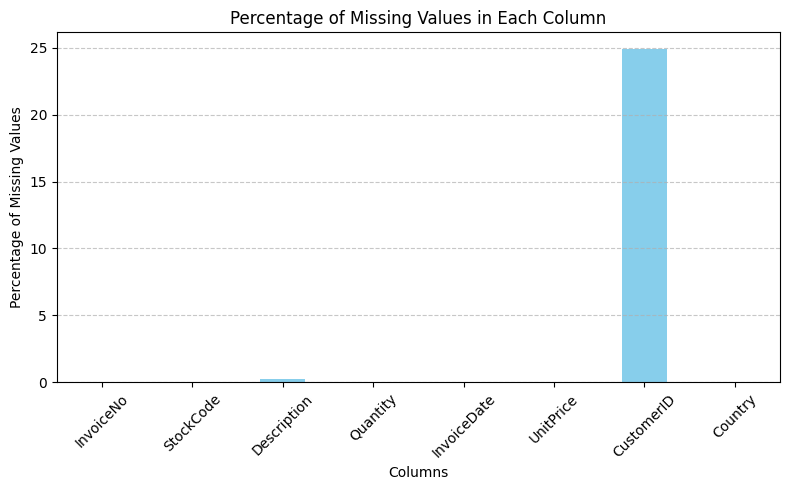

In [11]:
def check_missing_values(data):

    missing_values = df.isnull().sum()

    missing_percentage = (missing_values / len(data)) * 100

    missing_data = pd.DataFrame({'Total Missing Values': missing_values, 'Percentage': missing_percentage})

    return missing_data

def plot_missing_values(data):

    missing_data = check_missing_values(data)

    plt.figure(figsize=(8, 5))
    missing_data['Percentage'].plot(kind='bar', color='skyblue')
    plt.title('Percentage of Missing Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Missing Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


missing_data = check_missing_values(data)
print("Missing Values:")
print(missing_data)
plot_missing_values(data)

**Interpretations:**

So around 25% of records don't have customer id value,  But let's check further if there are any common records which have null and non-null customer ID but same invoice number, so that we can fill the records with same customer ID and try to decrease the loss.

In [13]:
df_cleaned = df.dropna(subset=['CustomerID'])
print("Number of null values after removing CustomerID nulls:", df_cleaned['CustomerID'].isnull().sum())

Number of null values after removing CustomerID nulls: 0


Therefore we are unable to prevent the loss and have to remove all such records before any further analysis.

In [14]:
df_eda = df_cleaned[~df_cleaned.InvoiceNo.str.contains('C', na=False)]


In [15]:
df_eda.shape

(392732, 8)

### **Exploratory Data Analysis**
Now let's do some Exploratory Data Analysis on the processed dataset

In [16]:
df_eda['Total_cost'] = df_cleaned.Quantity * df_cleaned.UnitPrice


In [17]:
oldest_date = df_eda['InvoiceDate'].min()
latest_date = df_eda['InvoiceDate'].max()
print("Start Date:", oldest_date)
print("End Date:", latest_date)

Start Date: 2010-12-01 08:26:00
End Date: 2011-12-09 12:50:00


In [18]:
df_eda['Country'].value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'


Country
United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: proportion, dtype: object

**Findings:**
* Almost 90% of records belong to the sales done in UK with some it's and bits in other countries.

In [19]:
df_eda['Week_of_Year'] = df_eda['InvoiceDate'].dt.isocalendar().week
df_eda['Day_of_Month'] = df_eda['InvoiceDate'].dt.day
df_eda['Month'] = df_eda['InvoiceDate'].dt.month
df_eda['Year'] = df_eda['InvoiceDate'].dt.year

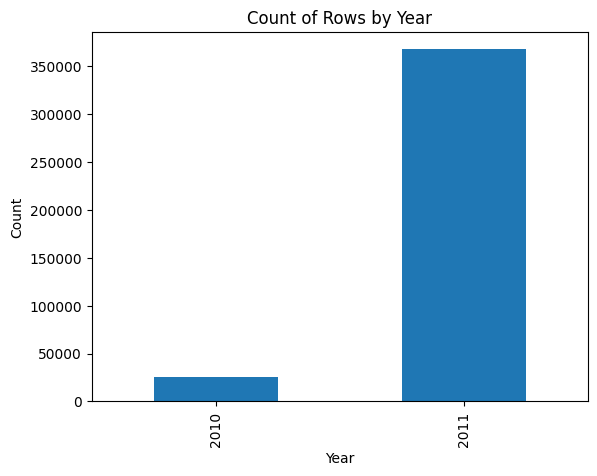

In [20]:
df_eda['Year'].value_counts(sort=False).plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Rows by Year')
plt.show()

**Interpretaions:**
* Since 2010 only includes transactions done in December, therefore it is evident that most of the records belong to 2011

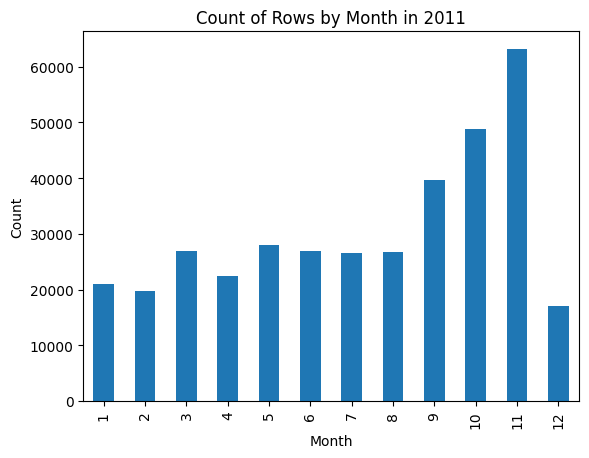

In [21]:
(df_eda[df_eda['Year'] == 2011]['Month'].value_counts().sort_index()).plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Rows by Month in 2011')
plt.show()

**Interpreations:**
* An increasing pattern can be observed month by month wise with a sharp decline in the month of December.
* That is evident because only first 8-9 days of December 2011 month is available in the dataset i.e. around 70% of the month transactions are not considered.
* Due to this fact, sales figure looks legitimate.

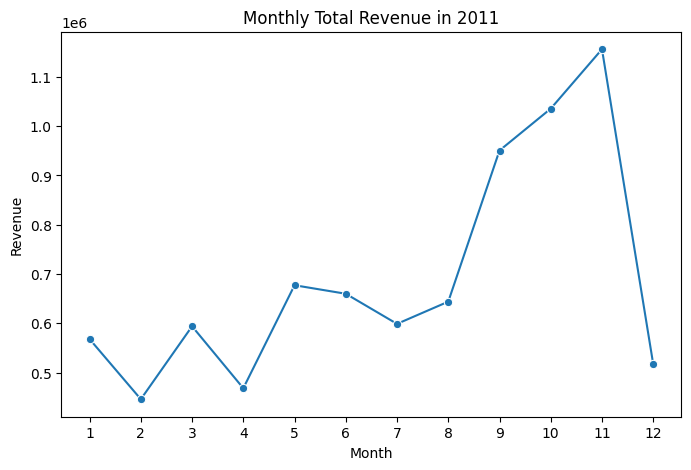

In [22]:
monthly_costs_2011 = df_eda[df_eda['Year'] == 2011].groupby('Month')['Total_cost'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(x=monthly_costs_2011['Month'], y=monthly_costs_2011['Total_cost'], marker='o', linewidth=1.5)
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Total Revenue in 2011')
plt.show()

**Interpreations:**
* A similar pattern is also observed in total gross each month as per the count of transactions in each month

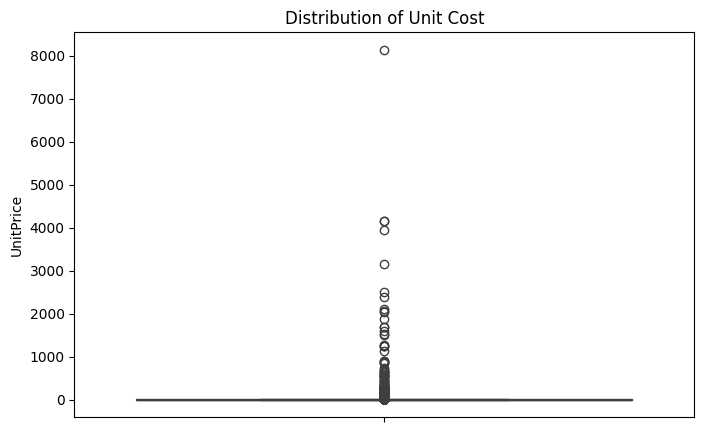

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(y='UnitPrice', data=df_eda, orient='h')
plt.title('Distribution of Unit Cost');

**Interpretaions:**
* Similarly, Price of unit data shows heavy skewed distribution towards lower values of unit price.



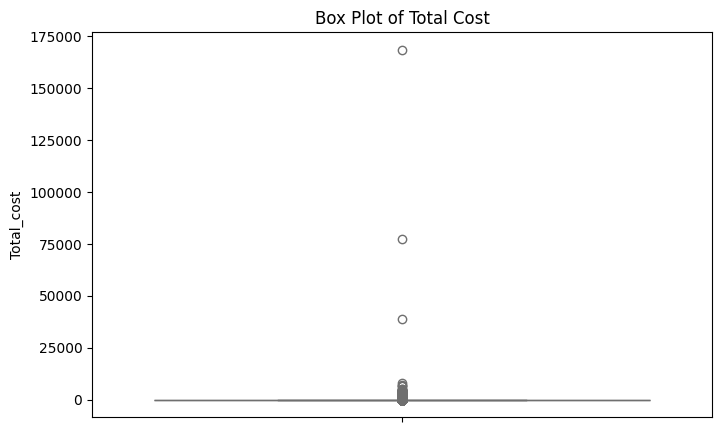

In [24]:
plt.figure(figsize=(8,5))
sns.boxplot( y='Total_cost', data=df_eda, color='skyblue', orient='h')
plt.title('Box Plot of Total Cost');

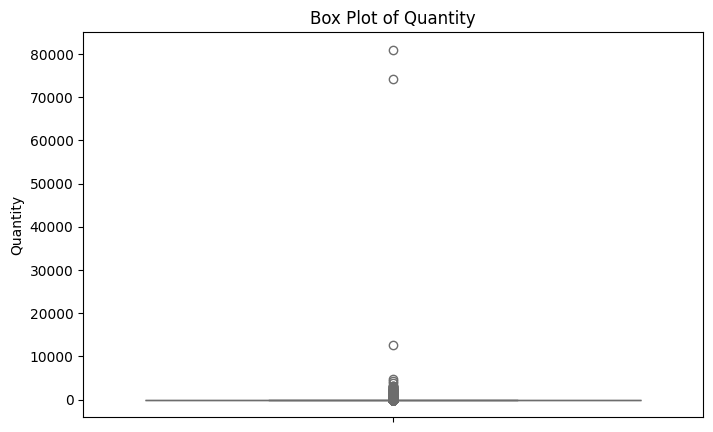

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot( y='Quantity',data=df_eda, color='salmon', orient='h')
plt.title('Box Plot of Quantity');

**Interpreatations:**
* This shows that Quantity data is highly skewed towards lower quantity values with some outliers. May be data entry error or might be genuine order



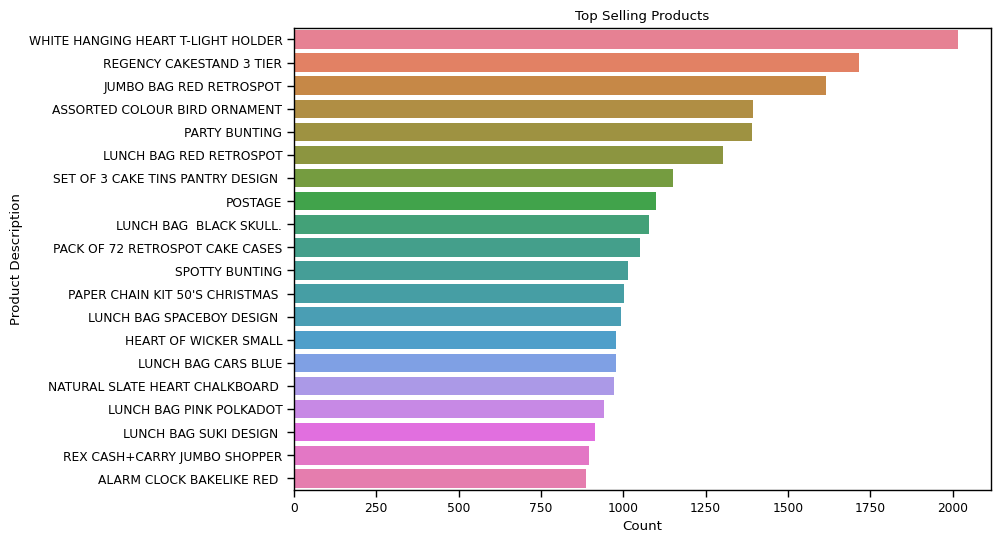

In [26]:
top_products = df_eda['Description'].value_counts().head(20)

colors = sns.color_palette('husl', 20)
plt.figure(figsize=(9, 6))
sns.set_context("paper", font_scale=1)
sns.barplot(x=top_products.values, y=top_products.index, palette=colors)
plt.title('Top Selling Products')
plt.xlabel('Count')
plt.ylabel('Product Description')
plt.show()

In [27]:
country_total_cost = df_eda.groupby('Country')['Total_cost'].sum().reset_index().sort_values(by='Total_cost', ascending=False).head(10)

fig = px.bar(country_total_cost,
             y='Country',
             x='Total_cost',
             orientation='h',
             title='Top 10 Country-wise Total Cost',
             labels={'Total_cost': 'Total Cost', 'Country': 'Country'},
             color='Country',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(width=900, height=600)
fig.update_layout(showlegend=False)
fig.show()

In [28]:
#import plotly.express as px

average_orders_per_month = df_eda.groupby('Month')['Quantity'].mean().reset_index()

# Create a line chart with Plotly
fig = px.line(average_orders_per_month,
              x='Month',
              y='Quantity',
              title='Average Order Placed per Month',
              labels={'Quantity': 'Average Orders'})

# Add data labels to the line chart
fig.update_traces(mode='markers+lines+text', text=average_orders_per_month['Quantity'].round(2),
                  textposition='top center', textfont_size=10)

fig.update_layout(width=900, height=500)
fig.show()

In [29]:
cohort = df_eda.copy()


In [30]:
cohort = cohort.rename(columns={'Total_cost': 'Revenue'})


In [31]:
cohort_analysis = cohort.drop(columns=['Week_of_Year', 'Day_of_Month', 'Month', 'Year'])

# **Cohort Analysis**
* A cohort is a group of subjects who share a defining characteristic.
* We can observe how a cohort behaves across time and compare it to other cohorts.

### **Cohort Analysis**: Customer Retention Analysis on Customer Level

### **Assign monthly acquisition cohort**
Defining a cohort is the first step to cohort analysis. We will now create monthly cohorts based on the month each customer has made their first transaction

In [32]:
# Define a function that will parse the date
def get_month(x):
    return dt.datetime(x.year,x.month,1)

cohort_analysis['InvoiceMonth'] = cohort_analysis['InvoiceDate'].apply(get_month)

grouping = cohort_analysis.groupby('CustomerID')['InvoiceMonth']

cohort_analysis['CohortMonth'] = grouping.transform('min')

In [33]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [34]:
invoice_year, invoice_month = get_date_int(cohort_analysis,'InvoiceMonth')

cohort_year, cohort_month = get_date_int(cohort_analysis,'CohortMonth')

In [35]:
years_diff = invoice_year - cohort_year

months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort_analysis['CohortIndex'] = years_diff * 12 + months_diff + 1

### **Calculate retention rate**
* Customer retention is a very useful metric to understand how many of all the customers are still active.
* It gives you the percentage of active customers compared to the total number of customers

In [36]:
grouping = cohort_analysis.groupby(['CohortMonth', 'CohortIndex'])

In [37]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes, axis=0)*100

In [38]:
cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,885
1,2010-12-01,2,324
2,2010-12-01,3,286
3,2010-12-01,4,340
4,2010-12-01,5,321


<Axes: xlabel='CohortMonth', ylabel='CustomerID'>

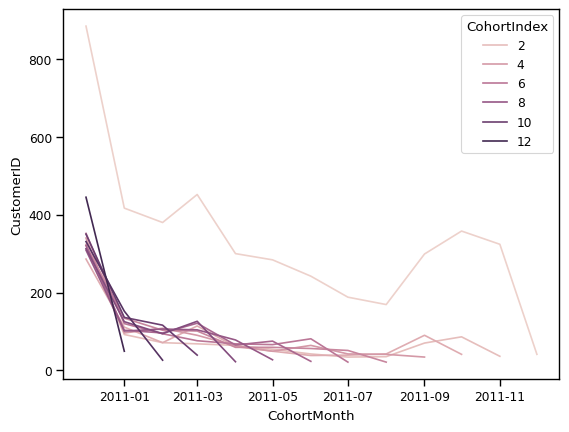

In [40]:
# @title Customers by Cohort over Time

sns.lineplot(x="CohortMonth", y="CustomerID", hue="CohortIndex", data=cohort_data)

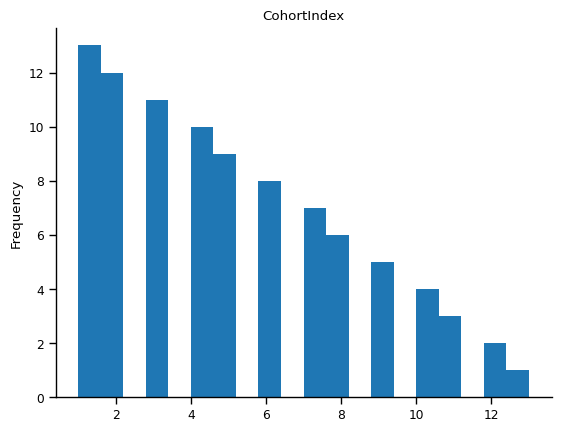

In [39]:
# @title CohortIndex

from matplotlib import pyplot as plt
cohort_data['CohortIndex'].plot(kind='hist', bins=20, title='CohortIndex')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [42]:
retention.head(12)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.00,36.61,32.32,38.42,36.27,39.77,36.27,34.92,35.37,39.55,37.40,50.28,26.55
2011-01-01,100.00,22.06,26.62,23.02,32.13,28.78,24.70,24.22,29.98,32.61,36.45,11.75,NaN
2011-02-01,100.00,18.68,18.68,28.42,27.11,24.74,25.26,27.89,24.74,30.53,6.84,NaN,NaN
2011-03-01,100.00,15.04,25.22,19.91,22.35,16.81,26.77,23.01,27.88,8.63,NaN,NaN,NaN
2011-04-01,100.00,21.33,20.33,21.00,19.67,22.67,21.67,26.00,7.33,NaN,NaN,NaN,NaN
2011-05-01,100.00,19.01,17.25,17.25,20.77,23.24,26.41,9.51,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.00,17.36,15.70,26.45,23.14,33.47,9.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.00,18.09,20.74,22.34,27.13,11.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.00,20.71,24.85,24.26,12.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


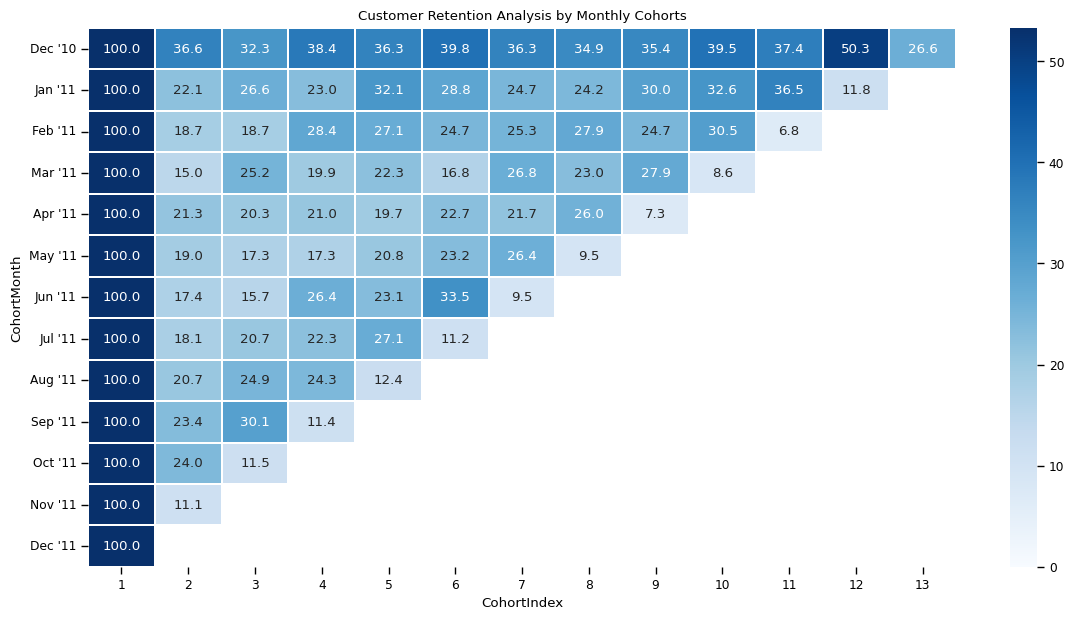

In [43]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

# Initialize inches plot figure
plt.figure(figsize=(14,7))

# Add a title
plt.title('Customer Retention Analysis by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=retention,
            annot = True,
            cmap = "Blues",
            vmin = 0.0,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show();

###**Cohort Analysis**: On Customer's Average Lifetime Value

### **Calculate Average Lifetime**
Now we will calculate the average revenue metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [44]:
# Calculate the average of the Revenue column
cohort_data_price = grouping['Revenue'].mean().reset_index()

# Create a pivot
average_price = cohort_data_price.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')
average_price.round(1)
average_price.index = average_price.index.date

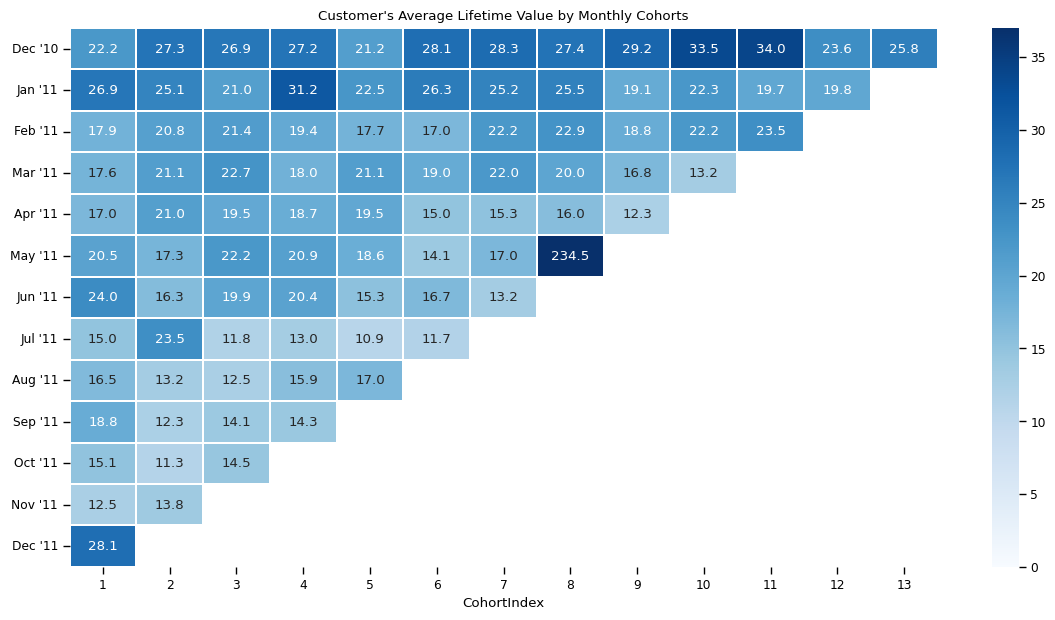

In [45]:
# Initialize plot figure
plt.figure(figsize=(14, 7))

# Add a title
plt.title("Customer's Average Lifetime Value by Monthly Cohorts")

# Create the heatmap
sns.heatmap(data = average_price,
            annot=True,
            vmin = 0.0,
#             vmax =20,
            cmap='Blues',
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

###**Cohort Analysis**: On Customer's Order Level




### **Calculate Customer's Total Order Level**
Now we will calculate the total order by customer metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [46]:
cohort_data_qty = grouping['InvoiceNo'].count().reset_index()

# Create a pivot
average_quantity = cohort_data_qty.pivot(index='CohortMonth', columns='CohortIndex', values='InvoiceNo')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

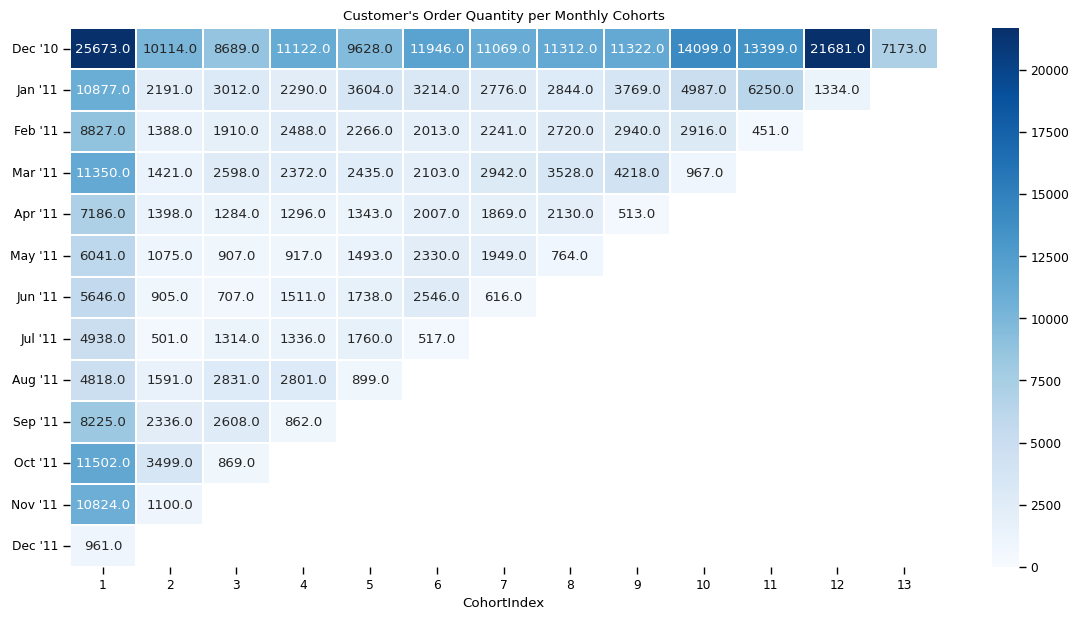

In [47]:
# Initialize plot figure
plt.figure(figsize=(14, 7))

# Add a title
plt.title("Customer's Order Quantity per Monthly Cohorts")

# Create the heatmap
sns.heatmap(data = average_quantity,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();